In [1]:
%load_ext kamu

In [2]:
%import_dataset matches

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,None,pyspark,idle,,,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%%sql -o df
select replay_json
from matches
where match_id = 'FE48264646657D56C5AEA4BDA79EC265'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

{0: [{'str': 'KrabbyPattie'}], 1: [{'str': 'LSHOWE'}], 2: [{'str': 'mross45'}], 3: [{'str': 'Flattix'}], 4: [{'str': 'ox_Adrenalin_xo'}], 5: [{'str': 'Kballs'}]}
cars: 12
cars: 23
cars: 24
cars: 34
cars: 51
cars: 55
cars: 95
cars: 108
cars: 179
cars: 178
cars: 177
cars: 150
cars: 149
cars: 143
cars: 92
cars: 91
cars: 90
cars: 88
cars: 87
cars: 53
cars: 99
cars: 183
cars: 85
cars: 91
cars: 97
cars: 35
cars: 131
cars: 137


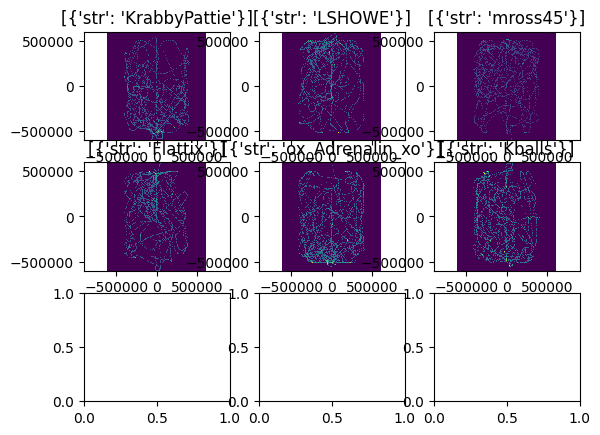

In [4]:
%%local
import json
import math
import os
import pathlib
from typing import List

from rattletrap import Replay

import numpy as np
from matplotlib import pyplot as plt

file_directory = pathlib.Path(".").parent.absolute()


# this script reads the RL replay file and parses it into a json(internally) using rattletrap.exe
# afterwards the necessary it extracted and then turned into a heatmap; see specific explanation below

player_ids = {}

player_int = []

player_nam = {}

#function for getting the xyz data for each player
def get_car_paths(replay: Replay) -> dict:
    actor_positions = {}
    # this first loop gathers the player names into a dict, and makes a dict for the ids of each player(see below)
    for index,names in enumerate(replay.header.data["body"]["properties"]["value"]["PlayerStats"]["value"]["array"]):
        player_ids[index] = []
        player_nam[index] = []
        player_nam[index].append(names["value"]["Name"]["value"])
    print(player_nam)
    # the extracted json uses "frames" to denote new information. not sure if a frame is made every x ms, or made when new info is needed
    for frame in replay.content.data["body"]["frames"][:]:
        # print(f"Time: {frame['time']}")
        for replication in frame["replications"]:
            #every frame has an actor id; data tied to that actor id. can be a car, ball, boost pads etc..
            actor_id = replication["actor_id"]["value"]
            #frames have spawned and update types. both can be in a single frame.
            if "spawned" in replication["value"]:
                if actor_id not in actor_positions:
                    #find a frame for which the spawn tag is for a car
                    if replication["value"]["spawned"]["object_name"] == "Archetypes.Car.Car_Default":
                        #initiate a empty array for the corresponding actor id.
                        actor_positions[actor_id] = []
            if "updated" in replication["value"]:
                for update in replication["value"]["updated"]:
                    #sometimes, new actor ids are spawned for the same player, here we find a frame with that info
                    #and then put all actor ids of each specific player into their corresponding array.

                    if update["name"] == "Engine.Pawn:PlayerReplicationInfo":
                        # print(update["value"]["flagged_int"]["int"])
                        if update["value"]["flagged_int"]["int"] not in player_int and update["value"]["flagged_int"]["int"] > 0:

                            #get the player identifier. this is different than an actor id.
                            player_int.append(update["value"]["flagged_int"]["int"])
                        #here we use the array generated at the top to store the multiple "car ids" of each player
                        for op in range(len(player_int)):
                            if update["value"]["flagged_int"]["int"] == player_int[op] and actor_id not in player_ids[op]:
                                player_ids[op].append(actor_id)
                                print("cars: "+ f"{actor_id}")
                    #finally, find the xyz data and add that to a dict for each "car id".
                    #the list we just made above is used later in the code to connect all the xyz data for each player together
                    if update["name"] == "TAGame.RBActor_TA:ReplicatedRBState" and actor_id in actor_positions:
                        rigid_body_location = update["value"]["rigid_body_state"]["location"]
                        # print(f"Body {actor_id} location: {rigid_body_location})
                        # append to name positions
                        actor_positions[actor_id].append({"x": rigid_body_location["x"], "y": rigid_body_location["y"]})

    return actor_positions

#function to get the boost amount for each player. it doesnt work properly. seems that a lot of data is missing.
#needs more exploring how the boost is displayed and updated in the game.
def get_car_boosts(replay: Replay) -> dict:
    actor_boosts = {}

    for frame in replay.content.data["body"]["frames"][:]:
        # print(f"Time: {frame['time']}")
        for replication in frame["replications"]:
            actor_id = replication["actor_id"]["value"]
            if "spawned" in replication["value"]:
                if actor_id not in actor_boosts:
                    if replication["value"]["spawned"]["object_name"] == "Archetypes.Car.Car_Default":
                        # print(f"Spawned car as actor {actor_id}")
                        actor_boosts[actor_id] = []
                    actor_boosts[actor_id] = []
            if "updated" in replication["value"]:
                ij = 0
                for update in replication["value"]["updated"]:
                    if update["name"] == "TAGame.CarComponent_TA:Vehicle":
                        ij = update["value"]["flagged_int"]["int"]
                    if update["name"] == "TAGame.CarComponent_Boost_TA:ReplicatedBoostAmount" and ij in actor_boosts:
                        boost = update["value"]["byte"]
                        actor_boosts[ij].append({"time": frame["time"], "boost": boost})
                        print("boost: "+ f"{ij}")

    return actor_boosts

#transform the stored xyz data into something we can use to plot later on.
def car_positions_to_histories(positions: dict) -> List['dict']:
    history_plots = []

    for actor_id in positions.keys():
        actor_history = positions[actor_id]
        xs = []
        ys = []
        for position in actor_history:
            xs.append(position["x"])
            ys.append(position["y"])
        xs = np.array(xs)
        ys = np.array(ys)
        if xs.shape[0] > 0:
            history_plots.append({
                "xs": xs,
                "ys": ys,
                "actor_id": actor_id
            })
    return history_plots

#RL is made in unreal. position data is a two decimal float. But in this implementation they are whole numbers,
# so a field of 6k unreal units large, needs a plot of 600k.
pmin = -600000
pmax = 600000
step = 8000
offset = int(((pmax - pmin) / step) / 2)
xx, yy = np.mgrid[pmin:pmax:step, pmin:pmax:step]


# -> np.ndarray
#convert the data we just transformed into a grid.
def history_to_heat_map(histories: List['dict']):
    heat_maps = {}
    graph = np.zeros(xx.shape)
    #here we add the xyz data of each "car id" to their player id.
    for index1 in range(len(player_ids)):
        for index3, history in enumerate(histories):

            if history["actor_id"] in player_ids[index1]:

                for px, py in zip(history["xs"], history["ys"]):
                    pxi = int(px / step) + offset
                    pyi = int(py / step) + offset
                    graph[pxi, pyi] += 1

        heat_maps[index1] = graph
        graph = np.zeros(xx.shape)

    return heat_maps

#rn unused function to transform the boost data for plotting
def boost_to_name(boost):
    # print(boost)
    boost_maps = {}
    time_maps = {}
    for index1 in range(len(player_ids)):
        boost_maps[index1] = []
        time_maps[index1] = []
        for index3, (b,c) in enumerate(boost.items()):
            if b in player_ids[index1]:

                for y in c:
                    # print(y["time"])
                    time_maps[index1].append(y["time"])
                    boost_maps[index1].append(y["boost"] / 2.55 )
    # print(len(boost_maps),len(time_maps))
        #boost data is not added chronologically, so this is fixed before plotting
        time_maps[index1], boost_maps[index1] = zip(*sorted(zip(time_maps[index1],boost_maps[index1])))
    return boost_maps, time_maps

#start the program by reading the file, and then go through the functions.
queried_replay = Replay.from_json(json.loads(df.loc[0].replay_json))
car_positions = get_car_paths(queried_replay)
car_histories = car_positions_to_histories(car_positions)
heat_map = history_to_heat_map(car_histories)

#normalize the heat maps
for i in range(len(heat_map)):

    heat_map[i] = heat_map[i] / np.max(heat_map[i])
    heat_map[i] = np.vectorize(lambda x: x ** 0.5)(heat_map[i])

#create a plot for each player and plot the data.
s = int(math.ceil(math.sqrt(len(heat_map))))
rows = s
cols = s
fig, ax = plt.subplots(nrows=rows, ncols=cols)
for i in range(len(heat_map)):
    x = int(i % cols)
    y = int((i - (i % cols)) / cols)

    ax[y, x].pcolor(xx, yy, heat_map[i])
    ax[y, x].set_xlim([-900000, 900000])
    ax[y, x].set_ylim([-600000, 600000])
    ax[y, x].set_title(player_nam[i])
#

# car_positions = get_car_paths(query_replay(os.path.join(file_directory, "42DA974B4E0844DEAF6AADBBA85CD8EA.replay")))
# car_histories = car_positions_to_histories(car_positions)
# heat_map += history_to_heat_map(car_histories)
#
# car_positions = get_car_paths(query_replay(os.path.join(file_directory, "84FBAB084C861E5925CEE08B7FA75E2B.replay")))
# car_histories = car_positions_to_histories(car_positions)
# heat_map += history_to_heat_map(car_histories)
#
# car_positions = get_car_paths(query_replay(os.path.join(file_directory, "96BCCFE049C422F4CDFC97868D48EDBA.replay")))
# car_histories = car_positions_to_histories(car_positions)
# heat_map += history_to_heat_map(car_histories)
#
# car_positions = get_car_paths(query_replay(os.path.join(file_directory, "E521C1274F7B363470362886606B1FC5.replay")))
# car_histories = car_positions_to_histories(car_positions)
# heat_map += history_to_heat_map(car_histories)

# heat_map[0] = heat_map[0] / np.max(heat_map[0])
# heat_map[0] = np.vectorize(lambda x: x**0.5)(heat_map[0])

# display.clear_output(wait=True)
# display.display(plt.gcf())
#

#plt.savefig("output/image.jpg",format="jpg",dpi=1200)

# items = get_car_boosts(queried_replay)
# items = {k: v for k, v in items.items() if len(v) > 0}
# # for a, (b,c) in enumerate(items.items()):
# #     print(a, b,c)
# boosts,times = boost_to_name(items)
# s = int(math.ceil(math.sqrt(len(boosts))))
#
# rows = s
# cols = s
#
# figs, axs = plt.subplots(nrows=rows,ncols=cols)
# # print(data)
# for i in range(len(boosts)):
#     x = int(i % cols)
#     y = int((i - (i % cols)) / cols)
#
#     # axs[y, x].scatter(times[i],boosts[i])
#     axs[y, x].plot(times[i],boosts[i])
#     axs[y, x].set_title(player_nam[i])

# plt.show()